# Recurrent Neural Networks

#### Google Stock Price

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Part 1 - Data Preprocessing

In [3]:
BASE_PATH  = "../../../Deep_Learning_Extended/Recurrent_Neural_Networks/"
TRAIN_PATH = BASE_PATH + "Google_Stock_Price_Train.csv"
TEST_PATH  = BASE_PATH + "Google_Stock_Price_Test.csv"

### Training Set

In [4]:
dataset_train = pd.read_csv(TRAIN_PATH)

In [5]:
training_set = dataset_train.iloc[:, 1:2].values

### Feature Scaling

In [6]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(training_set)

### Data Structure

In [7]:
X_train = []
y_train = []
timestamps = 60

In [8]:
for i in range(timestamps, len(dataset_train)):
    X_train.append(training_set_scaled[i - timestamps: i, 0])
    y_train.append(training_set_scaled[i, 0])

In [9]:
X_train = np.array(X_train)
y_train = np.array(y_train)

### Reshaping

In [10]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

In [11]:
X_train.shape

(1198, 60, 1)

## Part 2 - RNN

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [13]:
tf.random.set_seed(42)

regressor = Sequential()
regressor.add(LSTM(50, return_sequences=True, input_shape=(timestamps, 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(50, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(50, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(50))
regressor.add(Dropout(0.2))
regressor.add(Dense(1))

regressor.compile(optimizer='rmsprop', loss='mean_squared_error')

In [14]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [15]:
epochs = 100
batch_size = 32

regressor.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

Train on 1198 samples
Epoch 1/100
1198/1198 [==============================] - 4s 4ms/sample - loss: 0.0359
Epoch 2/100
1198/1198 [==============================] - 1s 512us/sample - loss: 0.0121
Epoch 3/100
1198/1198 [==============================] - 1s 507us/sample - loss: 0.0119
Epoch 4/100
1198/1198 [==============================] - 1s 507us/sample - loss: 0.0105
Epoch 5/100
1198/1198 [==============================] - 1s 508us/sample - loss: 0.0079
Epoch 6/100
1198/1198 [==============================] - 1s 506us/sample - loss: 0.0082
Epoch 7/100
1198/1198 [==============================] - 1s 506us/sample - loss: 0.0078
Epoch 8/100
1198/1198 [==============================] - 1s 508us/sample - loss: 0.0071
Epoch 9/100
1198/1198 [==============================] - 1s 508us/sample - loss: 0.0061
Epoch 10/100
1198/1198 [==============================] - 1s 506us/sample - loss: 0.0061
Epoch 11/100
1198/1198 [==============================] - 1s 510us/sample - loss: 0.0065
Epoch 12/1

In [16]:
regressor.save("google_stock_price.h5")

## Part 3 - Model Evaluation

### History

In [17]:
history = regressor.history.history
loss = history['loss']

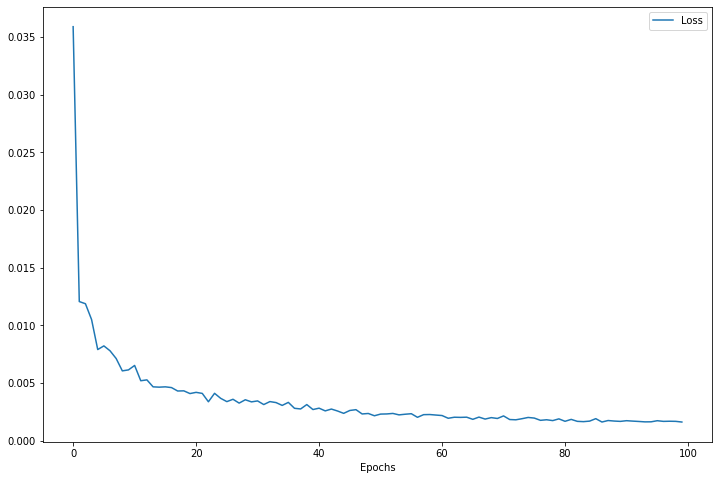

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(loss, label='Loss')
plt.legend()
plt.xlabel('Epochs')
plt.show()

### Prediction

#### Stock Price of January 2017

In [19]:
dataset_test = pd.read_csv(TEST_PATH)
real_stock_price = dataset_test.iloc[:, 1:2].values

dataset_total = pd.concat((dataset_train['Open'], 
                           dataset_test['Open']), axis=0)

inputs = dataset_total[len(dataset_total) - len(dataset_test) - timestamps:].values
inputs = inputs.reshape(len(inputs), 1)
inputs = sc.transform(inputs)

In [20]:
X_test = []

for i in range(timestamps, len(inputs)):
    X_test.append(inputs[i - timestamps: i, 0])

X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [21]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

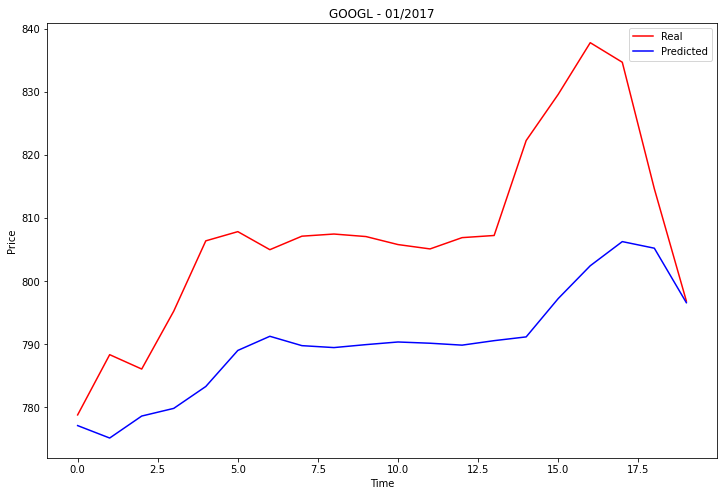

In [22]:
plt.figure(figsize=(12, 8))
plt.plot(real_stock_price, label="Real", color="red")
plt.plot(predicted_stock_price, label="Predicted", color="blue")
plt.title("GOOGL - 01/2017")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

#### Root Mean Squared Error

In [23]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))

In [24]:
print("Relative Error: ", rmse / real_stock_price.mean())

Relative Error:  0.02423283479183389
